<a href="https://colab.research.google.com/github/Zahra-Nafariyeh/Text_Classificaition/blob/main/1_Tensorflow_BERT_Virgool_Classificaition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://github.com/hooshvare/parsbert


Article: https://arxiv.org/abs/2005.12515

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
import os 
os.chdir('/content/gdrive/My Drive/Dataset')

In [6]:
!nvidia-smi

Tue Apr 27 04:25:39 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
# Install required packages

!pip install -q transformers
!pip install -q hazm
!pip install -q clean-text[gpl]

     |████████████████████████████████| 2.1MB 19.0MB/s 
     |████████████████████████████████| 901kB 46.8MB/s 
     |████████████████████████████████| 3.3MB 49.4MB/s 
     |████████████████████████████████| 317kB 18.0MB/s 
     |████████████████████████████████| 235kB 40.5MB/s 
     |████████████████████████████████| 1.4MB 48.5MB/s 
     |████████████████████████████████| 71kB 9.7MB/s 
     |████████████████████████████████| 133kB 34.5MB/s 
     |████████████████████████████████| 245kB 57.4MB/s 


In [8]:
# Import required packages

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.utils import shuffle

import hazm
from cleantext import clean

import plotly.express as px
import plotly.graph_objects as go

from tqdm.notebook import tqdm

import os
import re
import json
import copy
import collections

### Load the data using Pandas

In [10]:
import pandas as pd
df1 = pd.read_json('virgool_cleaned.json')
df1 = pd.DataFrame(df1['topic'])

import pandas as pd
df = pd.read_json('virgool_removed_word_112_4.json')

df_all = pd.concat([df, df1], axis=1)
df = df_all
df.head(3)

,text,topic
0,کسب اینترنت مهم بحث رشد فناوری اطلاعات مشاغل ا...,استارتاپ
1,نکات کلیدی کتاب شرکت امریکای دلار درامد محدودی...,استارتاپ
2,تولد لحظه گذشت استارتاپی شروع فراز فرود انتظار...,استارتاپ


In [11]:
data = df[['text', 'topic']]

data.head(3)

,text,topic
0,کسب اینترنت مهم بحث رشد فناوری اطلاعات مشاغل ا...,استارتاپ
1,نکات کلیدی کتاب شرکت امریکای دلار درامد محدودی...,استارتاپ
2,تولد لحظه گذشت استارتاپی شروع فراز فرود انتظار...,استارتاپ


In [12]:
# print data information
print('data information')
print(data.info(), '\n')

# print missing values information
print('missing values stats')
print(data.isnull().sum(), '\n')

# print some missing values
print('some missing values')
print(data[data['topic'].isnull()].iloc[:5], '\n')

data information
<class 'pandas.core.frame.DataFrame'>
Int64Index: 93479 entries, 0 to 93478
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    93479 non-null  object
 1   topic   93479 non-null  object
dtypes: object(2)
memory usage: 2.1+ MB
None 

missing values stats
text     0
topic    0
dtype: int64 

some missing values
Empty DataFrame
Columns: [text, topic]
Index: [] 



In [13]:
# handle some conflicts with the dataset structure
# you can find a reliable solution, for the sake of the simplicity
# I just remove these bad combinations!

# data['topic'] = data['topic'].apply(lambda r: r if r < 6 else None)

data = data.dropna(subset=['topic'])
data = data.dropna(subset=['text'])
data = data.drop_duplicates(subset=['text'], keep='first')
data = data.reset_index(drop=True)


# previous information after solving the conflicts

# print data information
print('data information')
print(data.info(), '\n')

# print missing values information
print('missing values stats')
print(data.isnull().sum(), '\n')

# print some missing values
print('some missing values')
print(data[data['topic'].isnull()].iloc[:5], '\n')

data information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73123 entries, 0 to 73122
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    73123 non-null  object
 1   topic   73123 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB
None 

missing values stats
text     0
topic    0
dtype: int64 

some missing values
Empty DataFrame
Columns: [text, topic]
Index: [] 



### Normalization / Preprocessing

The comments have different lengths based on words! Detecting the most normal range could help us find the maximum length of the sequences for the preprocessing step. On the other hand, we suppose that the minimum word combination for having a meaningful phrase for our learning process is 3.

In [14]:
# calculate the length of comments based on their words
data['comment_len_by_words'] = data['text'].apply(lambda t: len(hazm.word_tokenize(t)))

In [15]:
min_max_len = data["comment_len_by_words"].min(), data["comment_len_by_words"].max()
print(f'Min: {min_max_len[0]} \tMax: {min_max_len[1]}')

Min: 0 	Max: 1807


In [16]:
def data_gl_than(data, less_than=100.0, greater_than=0.0, col='comment_len_by_words'):
    data_length = data[col].values

    data_glt = sum([1 for length in data_length if greater_than < length <= less_than])

    data_glt_rate = (data_glt / len(data_length)) * 100

    print(f'Texts with word length of greater than {greater_than} and less than {less_than} includes {data_glt_rate:.2f}% of the whole!')

In [17]:
data_gl_than(data, 256, 3)

Texts with word length of greater than 3 and less than 256 includes 95.16% of the whole!


In [18]:
minlim, maxlim = 3, 256

In [19]:
# remove comments with the length of fewer than three words
data['comment_len_by_words'] = data['comment_len_by_words'].apply(lambda len_t: len_t if minlim < len_t <= maxlim else None)
data = data.dropna(subset=['comment_len_by_words'])
data = data.reset_index(drop=True)

In [20]:
fig = go.Figure()

fig.add_trace(go.Histogram(
    x=data['comment_len_by_words']
))

fig.update_layout(
    title_text='Distribution of word counts within comments',
    xaxis_title_text='Word Count',
    yaxis_title_text='Frequency',
    bargap=0.2,
    bargroupgap=0.2)

fig.show()

#یعنی 4 یا 5 تا داکیومنت بودند که طولشون 145 بوده    (145 و4-5)

In [21]:
unique_topics = list(sorted(data['topic'].unique()))
print(f'We have #{len(unique_topics)}: {unique_topics}')

We have #42: ['استارتاپ', 'اقتصاد', 'امنیت-سایبری', 'اینترنت-اشیا', 'بازاریابی', 'بازی-رایانه-ای', 'برنامه-نویسی', 'بهره-وری', 'تاریخ', 'تجربه-کاربری', 'تحصیلی-و-آموزشی', 'حقوقی', 'خانواده', 'خودشناسی', 'داستان', 'رابطه', 'روانشناسی', 'سفر', 'سلامت', 'سلامت-روانی', 'سیاست', 'شبکه-اجتماعی', 'شغل-و-کار', 'عکاسی', 'غذا', 'فرهنگ', 'فریلنسری', 'فلسفه', 'فیلم-و-سینما', 'فین-تک', 'محیط-زیست', 'مذهبی', 'مهندسی-نرم-افزار', 'موسیقی', 'موفقیت', 'هنر', 'هوا-فضا', 'هوش-مصنوعی', 'ورزشی', 'پول-رمزی', 'کارآفرینی', 'کتاب']


In [22]:
fig = go.Figure()

groupby_rate = data.groupby('topic')['topic'].count()

fig.add_trace(go.Bar(
    x=list(sorted(groupby_rate.index)),
    y=groupby_rate.tolist(),
    text=groupby_rate.tolist(),
    textposition='auto'
))

fig.update_layout(
    title_text='Distribution of topic within comments',
    xaxis_title_text='Topic',
    yaxis_title_text='Frequency',
    bargap=0.2,
    bargroupgap=0.2)

fig.show()

For simplicity, I transformed the rate in a range of 0.0 to 5.0 to a binary form of negative (0) or positive (1) with a threshold. If the rate is less than 3.0, it labeled as negative otherwise specified as positive.

In [23]:
# def rate_to_label(rate, threshold=3.0):
#     if rate <= threshold:
#         return 'negative'
#     else:
#         return 'positive'


# data['label'] = data['topic'].apply(lambda t: rate_to_label(t, 3.0))

# for i in range((df.shape[0])):
data.loc[(data.topic == "غذا" ), 'label'] = int(0)
data.loc[(data.topic == "امنیت-سایبری" ), 'label'] = int(1)
data.loc[(data.topic == "هوش-مصنوعی" ), 'label'] = 2
data.loc[(data.topic == "هوا-فضا" ), 'label'] = 3    
data.loc[(data.topic == "برنامه-نویسی" ), 'label'] = 4
# df.loc[(df.topic == "استارتاپ" ), 'label_t'] = 5

data.dropna(subset = ["label"], inplace=True)
data.head(3)
# df.shape




labels = list(sorted(data['label'].unique()))
data.head()

,text,topic,comment_len_by_words,label
6111,مدیرعامل حوزه امنیت جدید گزارش خانم موفق برتر ...,امنیت-سایبری,85.0,1.0
6112,شرکت اینترنت دورانتاش انتی ویروس انتخاب توافق ...,امنیت-سایبری,105.0,1.0
6113,رهبر بازار معرف فصل جدید گزارش مربوط کمپانی اخ...,امنیت-سایبری,89.0,1.0
6114,نقص سیستم عامل نرم افزار اینترنت وصل اپدیت نتی...,امنیت-سایبری,67.0,1.0
6115,دوستان اوضاع ماه درگیر دوره جالب سنگین مطالب ت...,امنیت-سایبری,125.0,1.0


Cleaning is the final step in this section. Our cleaned method includes these steps:

- fixing unicodes
- removing specials like a phone number, email, url, new lines, ...
- cleaning HTMLs
- normalizing
- removing emojis

In [24]:
def cleanhtml(raw_html):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', raw_html)
    return cleantext


def cleaning(text):
    text = text.strip()
    
    # regular cleaning
    text = clean(text,
        fix_unicode=True,
        to_ascii=False,
        lower=True,
        no_line_breaks=True,
        no_urls=True,
        no_emails=True,
        no_phone_numbers=True,
        no_numbers=False,
        no_digits=False,
        no_currency_symbols=True,
        no_punct=False,
        replace_with_url="",
        replace_with_email="",
        replace_with_phone_number="",
        replace_with_number="",
        replace_with_digit="0",
        replace_with_currency_symbol="",
    )

    # cleaning htmls
    text = cleanhtml(text)
    
    # normalizing
    normalizer = hazm.Normalizer()
    text = normalizer.normalize(text)
    
    # removing wierd patterns
    wierd_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u'\U00010000-\U0010ffff'
        u"\u200d"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\u3030"
        u"\ufe0f"
        u"\u2069"
        u"\u2066"
        # u"\u200c"
        u"\u2068"
        u"\u2067"
        "]+", flags=re.UNICODE)
    
    text = wierd_pattern.sub(r'', text)
    
    # removing extra spaces, hashtags
    text = re.sub("#", "", text)
    text = re.sub("\s+", " ", text)
    
    return text

In [25]:
# cleaning comments
data['cleaned_comment'] = data['text'].apply(cleaning)


# calculate the length of comments based on their words
data['cleaned_comment_len_by_words'] = data['cleaned_comment'].apply(lambda t: len(hazm.word_tokenize(t)))

# remove comments with the length of fewer than three words
data['cleaned_comment_len_by_words'] = data['cleaned_comment_len_by_words'].apply(lambda len_t: len_t if minlim < len_t <= maxlim else len_t)
data = data.dropna(subset=['cleaned_comment_len_by_words'])
data = data.reset_index(drop=True)

data.head()

,text,topic,comment_len_by_words,label,cleaned_comment,cleaned_comment_len_by_words
0,مدیرعامل حوزه امنیت جدید گزارش خانم موفق برتر ...,امنیت-سایبری,85.0,1.0,مدیرعامل حوزه امنیت جدید گزارش خانم موفق برتر ...,85
1,شرکت اینترنت دورانتاش انتی ویروس انتخاب توافق ...,امنیت-سایبری,105.0,1.0,شرکت اینترنت دورانتاش انتی ویروس انتخاب توافق ...,105
2,رهبر بازار معرف فصل جدید گزارش مربوط کمپانی اخ...,امنیت-سایبری,89.0,1.0,رهبر بازار معرف فصل جدید گزارش مربوط کمپانی اخ...,89
3,نقص سیستم عامل نرم افزار اینترنت وصل اپدیت نتی...,امنیت-سایبری,67.0,1.0,نقص سیستم عامل نرم افزار اینترنت وصل اپدیت نتی...,67
4,دوستان اوضاع ماه درگیر دوره جالب سنگین مطالب ت...,امنیت-سایبری,125.0,1.0,دوستان اوضاع ماه درگیر دوره جالب سنگین مطالب ت...,125


In [26]:
data = data[['cleaned_comment', 'label']]
data.columns = ['text', 'label']
data.head()

,text,label
0,مدیرعامل حوزه امنیت جدید گزارش خانم موفق برتر ...,1.0
1,شرکت اینترنت دورانتاش انتی ویروس انتخاب توافق ...,1.0
2,رهبر بازار معرف فصل جدید گزارش مربوط کمپانی اخ...,1.0
3,نقص سیستم عامل نرم افزار اینترنت وصل اپدیت نتی...,1.0
4,دوستان اوضاع ماه درگیر دوره جالب سنگین مطالب ت...,1.0


In [27]:
print(f'We have #{len(labels)} labels: {labels}')

We have #5 labels: [0.0, 1.0, 2.0, 3.0, 4.0]


### Handling Unbalanced Data

In [28]:
fig = go.Figure()

groupby_label = data.groupby('label')['label'].count()

fig.add_trace(go.Bar(
    x=list(sorted(groupby_label.index)),
    y=groupby_label.tolist(),
    text=groupby_label.tolist(),
    textposition='auto'
))

fig.update_layout(
    title_text='Distribution of label within comments [DATA]',
    xaxis_title_text='Label',
    yaxis_title_text='Frequency',
    bargap=0.2,
    bargroupgap=0.2)

fig.show()

Again, for making things simple. We cut the dataset randomly based on the fewer label, the negative class.

In [29]:
# negative_data = data[data['label'] == 'negative']
# positive_data = data[data['label'] == 'positive']

# cutting_point = min(len(negative_data), len(positive_data))

# if cutting_point <= len(negative_data):
#     negative_data = negative_data.sample(n=cutting_point).reset_index(drop=True)

# if cutting_point <= len(positive_data):
#     positive_data = positive_data.sample(n=cutting_point).reset_index(drop=True)
# data = data.target.resample(0)
# print("class 0 : ",data[data.target == 0].shape) 
from sklearn.utils import resample

# Upsample minority class #2770
class_0 = resample( data[data.label== 0 ], 
                                replace=True,     # sample with replacement
                                n_samples=4114,    # to match majority class
                                random_state=123) # reproducible results

class_1 = resample( data[data.label== 1 ], 
                                replace=True,     # sample with replacement
                                n_samples=4114,    # to match majority class
                                random_state=123) # reproducible results

class_2 = resample( data[data.label== 2 ], 
                                replace=True,     # sample with replacement
                                n_samples=4114,    # to match majority class
                                random_state=123) # reproducible results 

class_3 = resample( data[data.label== 3 ], 
                                replace=True,     # sample with replacement
                                n_samples=4114,    # to match majority class
                                random_state=123) # reproducible results

class_4 = resample( data[data.label== 4 ], 
                                replace=True,     # sample with replacement
                                n_samples=4114,    # to match majority class
                                random_state=123) # reproducible results 
                                                                                                                                                                                                                              




new_data = pd.concat([class_0, class_1 , class_2 , class_3, class_4])
new_data = new_data.sample(frac=1).reset_index(drop=True)
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20570 entries, 0 to 20569
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   text    20570 non-null  object 
 1   label   20570 non-null  float64
dtypes: float64(1), object(1)
memory usage: 321.5+ KB


In [30]:
fig = go.Figure()

groupby_label = new_data.groupby('label')['label'].count()

fig.add_trace(go.Bar(
    x=list(sorted(groupby_label.index)),
    y=groupby_label.tolist(),
    text=groupby_label.tolist(),
    textposition='auto'
))

fig.update_layout(
    title_text='Distribution of label within comments [NEW DATA]',
    xaxis_title_text='Label',
    yaxis_title_text='Frequency',
    bargap=0.2,
    bargroupgap=0.2)

fig.show()

In [31]:
new_data.head()

,text,label
0,علاقه حوزه هوش مصنوع مفاهیم پردازش تصویر ماشین...,2.0
1,صفو اینده تصور جواب بینی واقعیت پنجاه حدس دقیق...,2.0
2,مقاله اموزش برسی دستور رفع خطا پرداخته همراه و...,4.0
3,کارشناس امنیت باری مایکروسافت اژانس ایالات متح...,1.0
4,اسپیس ایل ماسک صحبت میذاشتم فضا ایده انسان دوس...,3.0


## Train,Validation,Test split

To achieve a globalized model, we need to split the cleaned dataset into train, valid, test sets due to size of the data. In this tutorial, I have considered a rate of **0.1** for both *valid*, *test* sets. For splitting, I use `train_test_split` provided by Sklearn package with stratifying on the label for preserving the distribution balance.

In [32]:
new_data['label_id'] = new_data['label'].apply(lambda t: labels.index(t))

train, test = train_test_split(new_data, test_size=0.1, random_state=1, stratify=new_data['label'])
train, valid = train_test_split(train, test_size=0.1, random_state=1, stratify=train['label'])

train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)
test = test.reset_index(drop=True)

x_train, y_train = train['text'].values.tolist(), train['label_id'].values.tolist()
x_valid, y_valid = valid['text'].values.tolist(), valid['label_id'].values.tolist()
x_test, y_test = test['text'].values.tolist(), test['label_id'].values.tolist()

print(train.shape)
print(valid.shape)
print(test.shape)

(16661, 3)
(1852, 3)
(2057, 3)


Now, my favorite part comes. First of all, I follow the model using *PyTorch*, and next, do the same processes using *TensorFlow* and finally use the ParsBERT script to do all the things once in a desired form for HuggignFace.

![BERT INPUTS](https://res.cloudinary.com/m3hrdadfi/image/upload/v1595158991/kaggle/bert_inputs_w8rith.png)

As you may know, the BERT model input is a combination of 3 embeddings.
- Token embeddings: WordPiece token vocabulary (WordPiece is another word segmentation algorithm, similar to BPE)
- Segment embeddings: for pair sentences [A-B] marked as $E_A$ or $E_B$ mean that it belongs to the first sentence or the second one.
- Position embeddings: specify the position of words in a sentence

## TensorFlow

In [33]:
from transformers import BertConfig, BertTokenizer
from transformers import TFBertModel, TFBertForSequenceClassification
from transformers import glue_convert_examples_to_features

import tensorflow as tf

### Configuration

In [34]:
# general config
MAX_LEN = 128
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 16
TEST_BATCH_SIZE = 16

EPOCHS = 3
EEVERY_EPOCH = 1000
LEARNING_RATE = 2e-5
CLIP = 0.0

MODEL_NAME_OR_PATH = 'HooshvareLab/bert-fa-base-uncased'
OUTPUT_PATH = '/content/bert-fa-base-uncased-sentiment-taaghceh/pytorch_model.bin'

os.makedirs(os.path.dirname(OUTPUT_PATH), exist_ok=True)

In [35]:
label2id = {label: i for i, label in enumerate(labels)}
id2label = {v: k for k, v in label2id.items()}

print(f'label2id: {label2id}')
print(f'id2label: {id2label}')

label2id: {0.0: 0, 1.0: 1, 2.0: 2, 3.0: 3, 4.0: 4}
id2label: {0: 0.0, 1: 1.0, 2: 2.0, 3: 3.0, 4: 4.0}


In [36]:
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME_OR_PATH)
config = BertConfig.from_pretrained(
    MODEL_NAME_OR_PATH, **{
        'label2id': label2id,
        'id2label': id2label,
    })

print(config.to_json_string())


{
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": 0.0,
    "1": 1.0,
    "2": 2.0,
    "3": 3.0,
    "4": 4.0
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "0.0": 0,
    "1.0": 1,
    "2.0": 2,
    "3.0": 3,
    "4.0": 4
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.5.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 100000
}



### Input Embeddings / Dataset

In [37]:
class InputExample:
    """ A single example for simple sequence classification. """

    def __init__(self, guid, text_a, text_b=None, label=None):
        """ Constructs a InputExample. """
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label


def make_examples(tokenizer, x, y=None, maxlen=128, output_mode="classification", is_tf_dataset=True):
    examples = []
    y = y if isinstance(y, list) or isinstance(y, np.ndarray) else [None] * len(x)

    for i, (_x, _y) in tqdm(enumerate(zip(x, y)), position=0, total=len(x)):
        guid = "%s" % i
        label = int(_y)
        
        if isinstance(_x, str):
            text_a = _x
            text_b = None
        else:
            assert len(_x) == 2
            text_a = _x[0]
            text_b = _x[1]
        
        examples.append(InputExample(guid=guid, text_a=text_a, text_b=text_b, label=label))
    
    features = glue_convert_examples_to_features(
        examples, 
        tokenizer, 
        maxlen, 
        output_mode=output_mode, 
        label_list=list(np.unique(y)))

    all_input_ids = []
    all_attention_masks = []
    all_token_type_ids = []
    all_labels = []

    for f in tqdm(features, position=0, total=len(examples)):
        if is_tf_dataset:
            all_input_ids.append(tf.constant(f.input_ids))
            all_attention_masks.append(tf.constant(f.attention_mask))
            all_token_type_ids.append(tf.constant(f.token_type_ids))
            all_labels.append(tf.constant(f.label))
        else:
            all_input_ids.append(f.input_ids)
            all_attention_masks.append(f.attention_mask)
            all_token_type_ids.append(f.token_type_ids)
            all_labels.append(f.label)

    if is_tf_dataset:
        dataset = tf.data.Dataset.from_tensor_slices(({
            'input_ids': all_input_ids,
            'attention_mask': all_attention_masks,
            'token_type_ids': all_token_type_ids
        }, all_labels))

        return dataset, features
    
    xdata = [np.array(all_input_ids), np.array(all_attention_masks), np.array(all_token_type_ids)]
    ydata = all_labels

    return [xdata, ydata], features

In [38]:
train_dataset_base, train_examples = make_examples(tokenizer, x_train, y_train, maxlen=128)
valid_dataset_base, valid_examples = make_examples(tokenizer, x_valid, y_valid, maxlen=128)

test_dataset_base, test_examples = make_examples(tokenizer, x_test, y_test, maxlen=128)
[xtest, ytest], test_examples = make_examples(tokenizer, x_test, y_test, maxlen=128, is_tf_dataset=False)

/usr/local/lib/python3.7/dist-packages/transformers/data/processors/glue.py:67: FutureWarning:

This function will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/text-classification/run_glue.py



In [39]:
for value in train_dataset_base.take(1):
    print(f'     input_ids: {value[0]["input_ids"]}')
    print(f'attention_mask: {value[0]["attention_mask"]}')
    print(f'token_type_ids: {value[0]["token_type_ids"]}')
    print(f'        target: {value[1]}')

     input_ids: [    2 67138 63863  2795  4373  7289 10782  8336 71117  3919  8417  3948
  3357  3629  6597 10884  2910  5232 27989  2005  3805  4836 17730  3598
     4     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]
attention_mask: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [40]:
def get_training_dataset(dataset, batch_size):
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size)

    return dataset

def get_validation_dataset(dataset, batch_size):
    dataset = dataset.batch(batch_size)

    return dataset

In [41]:
train_dataset = get_training_dataset(train_dataset_base, TRAIN_BATCH_SIZE)
valid_dataset = get_training_dataset(valid_dataset_base, VALID_BATCH_SIZE)

train_steps = len(train_examples) // TRAIN_BATCH_SIZE
valid_steps = len(valid_examples) // VALID_BATCH_SIZE

train_steps, valid_steps

(1041, 115)

### Model

In [42]:
def build_model(model_name, config, learning_rate=3e-5):
    model = TFBertForSequenceClassification.from_pretrained(model_name, config=config)

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
    model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

    return model

In [43]:
model = build_model(MODEL_NAME_OR_PATH, config, learning_rate=LEARNING_RATE)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at HooshvareLab/bert-fa-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [44]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  162841344 
_________________________________________________________________
dropout_37 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  3845      
Total params: 162,845,189
Trainable params: 162,845,189
Non-trainable params: 0
_________________________________________________________________


### Training

In [45]:
%%time

r = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    epochs=EPOCHS,
    verbose=1)

final_accuracy = r.history['val_accuracy']
print('FINAL ACCURACY MEAN: ', np.mean(final_accuracy))

Epoch 1/3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autogr

In [46]:
# save the model

model.save_pretrained(os.path.dirname(OUTPUT_PATH))

### Evaluation / Prediction

In [47]:
ev = model.evaluate(test_dataset_base.batch(TEST_BATCH_SIZE))
print()
print(f'Evaluation: {ev}')
print()

predictions = model.predict(xtest)
ypred = predictions[0].argmax(axis=-1).tolist()

print()
print(classification_report(ytest, ypred))
# print(classification_report(ytest, ypred, target_names= labels))

print()

print(f'F1: {f1_score(ytest, ypred, average="weighted")}')

129/129 [==============================] - 18s 140ms/step - loss: 0.0670 - accuracy: 0.9820

Evaluation: [0.06697806715965271, 0.9820126295089722]


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       412
           1       0.94      0.99      0.96       411
           2       1.00      1.00      1.00       411
           3       1.00      1.00      1.00       412
           4       0.99      0.93      0.96       411

    accuracy                           0.98      2057
   macro avg       0.98      0.98      0.98      2057
weighted avg       0.98      0.98      0.98      2057


F1: 0.9819812766849446


In [48]:
from sklearn import metrics 
print(metrics.classification_report(ytest, ypred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       412
           1       0.94      0.99      0.96       411
           2       1.00      1.00      1.00       411
           3       1.00      1.00      1.00       412
           4       0.99      0.93      0.96       411

    accuracy                           0.98      2057
   macro avg       0.98      0.98      0.98      2057
weighted avg       0.98      0.98      0.98      2057



##Plot Loss And Accuracy

In [49]:
import matplotlib.pyplot as plt

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

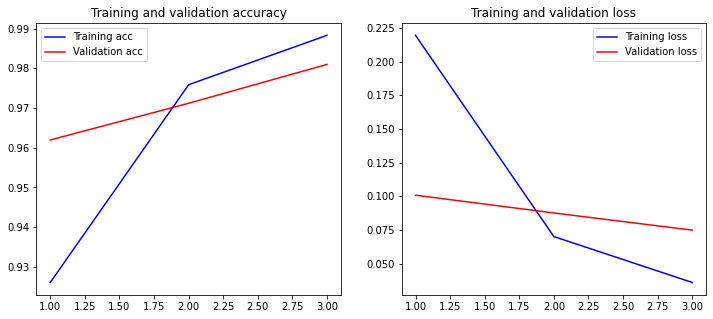

In [50]:
plot_history(r)